In [55]:
#Imports
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, \
RidgeCV, ElasticNet, ElasticNetCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,\
                                  PolynomialFeatures

from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_squared_error

data: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Load the data

[reset pandas display options](https://stackoverflow.com/questions/26246864/restoring-the-default-display-context-in-pandas)

In [13]:
houses = pd.read_csv('../datasets/train.csv')
houses_test = pd.read_csv('../datasets/test.csv')
pd.reset_option('^display.', silent=True)

In [14]:
houses.columns = [col.lower().replace(" ", '_').replace("/", '_')  for col in \
                        houses.columns]
houses_test.columns = [col.lower().replace(" ", '_').replace("/", '_')  \
                       for col in houses_test.columns]

In [15]:
houses.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod_add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

#### missing vals

##### missing vals resources

[how to handle missing values](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=When%20column%20has%20more%20than,%25%20missing%20value%2C%20drop%20it.)

##### missing values analysis

In [16]:
houses.describe()

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [ ]:
houses.isnull().sum().sort_values(ascending = False)[lambda x:x>0]

###### Column Dropping:

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651

There don't seem to be many pools in Ames (9).  Likewise, only 65 houses have Miscelaneous Features (3.17%), so I believe it is reasonable to drop this feature.  Also, there are 1911 out of 2051 houses without an alley.  I'm going to remove this feature.  There are a significant number of fences (400), so I'll impute "None" for the NA values. It would be difficult to draw conclusions from columns 'Pool QC' and 'Pool Area', as there are only 9 houses with pools. 

Likewise for Misc Feature, Alley, and Fence, these do not strike me as frequent enough and/or important enough to include as a predictive feature.  I will drop all four columns.

I'll drop PID because this feature is reduntant with ID for data identification purposes.  ID I will keep for maintining identification of the data.  

In [18]:
dropped_columns = ['pid','misc_feature','misc_val','alley','pool_qc', 'pool_area']
houses.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_id = houses.pop('id')

In [19]:
houses_test.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_test_id = houses_test.pop('id')

Changing the 'ms_subclass' feature to categorical.

In [20]:
houses['ms_subclass'] = houses['ms_subclass'].astype('category')

In [ ]:
houses.columns

I will also collect column names for ordinal encoding vs. One-Hot encoding.  

In [21]:
target = ['saleprice']   
 
features_ord = ['lot_shape','utilities','land_slope','overall_qual',\
'overall_cond', 'exter_qual','exter_cond', 'bsmt_qual', 'bsmt_cond', \
'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2','heating_qc','electrical',\
'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual',
'garage_cond', 'paved_drive', 'fence']

features_nom = ['ms_subclass','ms_zoning','street','land_contour',\
'lot_config','neighborhood','condition_2','bldg_type','house_style', \
'roof_style', 'roof_matl','exterior_1st','exterior_2nd', 'mas_vnr_type',\
'foundation','heating','central_air', 'garage_type', 'misc_val', 'sale_type',]

features_cont = ['lot_frontage','lot_area','mas_vnr_area','bsmtfin_sf_1',\
'bsmtfin_sf_2','bsmt_unf_sf', 'total_bsmt_sf','1st_flr_sf', '2nd_flr_sf', \
'low_qual_fin_sf','gr_liv_area', 'garage_area', 'wood_deck_sf', 'open_porch_sf',\
'enclosed_porch','3ssn_porch', 'screen_porch', ]

features_disc = ['year_built', 'year_remod_add','bsmt_full_bath',\
'bsmt_half_bath', 'full_bath', 'half_bath','bedroom_abvgr', 'kitchen_abvgr',\
'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'mo_sold', \
'yr_sold',]
features_type = [features_ord,features_nom,features_cont,features_disc]
features_all = features_ord + features_nom + features_cont + features_disc

```To-do:``` I will make 'month_sold' a nominal variable:

```To-do:``` months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec']

houses['month_sold'] = []


For columns that have NA values, the data dictionary indicates that the feature does not exist for the observation, as opposed to indicating that there was not any record.  The columns with na values that indicate the feature is not present for a given observation include:

Fence, FireplaceQu (and 'Fireplaces' ?), 

Garage Cond, Garage Qual, ('Garage Area' ?), Garage Cars, Garage Finish, Garage Yr Blt, Garage Type
Note: there is one fewer Garage Type NAs than there are NA's for the other garage features.  I need to investigate further.

Bsmt features are also asymetrically missing values, which needs to be investigated.  

Mas Vnr does not rely on NA's but instead has 'None' as a value to indicate if a feature is missing.  Imputing with the mode may be the best option here.



There are a significant number of fireplaces and Na values for Fireplace Qu indicate no fireplace, so I will replace the missing values with ```'None'``` .

Only 65 houses with misc features.  Shed is the most common of these with 56, but the median sale price is not much different (163,000.0 with no shed vs 153,750.0 with a shed)

I believe that in accordance with the format for other columns, the missing values for lot frontage likely indicate that the lot has no frontage.  This assumption is supported by the observation that the minimum recorded frontage is greater than zero. I will impute zeros in place of the NAs.

In [ ]:
houses.isna().sum().value_counts()

In [ ]:
houses.dtypes

In [23]:
#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

houses_numeric = houses.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')

houses_numeric = pd.DataFrame(si.fit_transform(houses_numeric),\
                              columns = houses_numeric.columns)

houses_obj = houses.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

houses_obj_imputed = si.fit_transform(houses_obj)

houses_obj = pd.DataFrame(houses_obj_imputed, columns = houses_obj.\
                              columns)
houses_imp = houses_numeric.join(houses_obj)

houses_imp.describe()

#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype


,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,mo_sold,yr_sold,saleprice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,57.944417,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,...,1.775719,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,6.219893,2007.775719,181469.701609
std,42.824223,33.137332,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,...,0.765357,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,2.744736,1.312014,79258.659352
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,43.500000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,...,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,50.000000,63.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,...,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,...,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,12.000000,2010.000000,611657.000000


In [ ]:
# imputing test data
houses_test_numeric = houses_test.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')
si.fit(houses_test_numeric)
houses_test_numeric_imputed = si.transform(houses_test_numeric)
houses_test_numeric = pd.DataFrame(houses_test_numeric_imputed, columns = houses_test_numeric.\
                              columns)

houses_test_obj = houses_test.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

si.fit(houses_test_obj)
houses_test_obj_imputed = si.transform(houses_test_obj)
houses_test_obj = pd.DataFrame(houses_test_obj_imputed, columns = houses_test_obj.\
                              columns)
houses_test_imp = houses_test_numeric.join(houses_test_obj)

houses_test_imp.describe()

In [24]:
def zero_counts(dataframe):
    zero_counts_dict = {col:dataframe.loc[dataframe[col]==0,col].count() \
               for col in dataframe.columns}
    zero_counts_df = pd.DataFrame.from_dict(data = zero_counts_dict, \
                                            orient = 'index',\
                                            columns = ['zero_counts'])
    zero_counts_df_sorted = zero_counts_df.sort_values(by = 'zero_counts', \
                                                       ascending = False)
    return zero_counts_df_sorted.loc[zero_counts_df_sorted['zero_counts']>0,:]

zero_counts(houses_imp)


,zero_counts
3ssn_porch,2025
low_qual_fin_sf,2018
bsmt_half_bath,1925
screen_porch,1870
bsmtfin_sf_2,1804
enclosed_porch,1724
half_bath,1308
mas_vnr_area,1238
bsmt_full_bath,1202
2nd_flr_sf,1191


In [ ]:
# https://stackoverflow.com/questions/1007481/how-to-replace-whitespaces-with-\
# underscore
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/

# rename_dict = dict(map(lambda i,j : (i,j) , houses_imp.columns,[col.replace(' ','_') for col in houses_imp.columns]))

# houses_imp.columns

In [ ]:
import numpy as np

In [ ]:
def ft_price_sd(df,features,target):
    target_sd_by_feature =  {feat:np.std(df.groupby([feat])[target].mean().values)\
            for feat in features}
    return pd.DataFrame.from_dict(target_sd_by_feature, orient='index', columns\
            = ['target_sd']).sort_values(by = 'target_sd', ascending = False)

cat_price_sd = ft_price_sd(houses_imp, houses_obj.columns, 'saleprice')


In [ ]:
# cat_price_sd

[plotting ref1](https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot)
[plotting ref2](https://www.reddit.com/r/learnpython/comments/3cjnpg/seaborn_xaxis_as_index/)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

p1 = sns.barplot(data = cat_price_sd.reset_index(), x = 'target_sd', y = 'index', \
            color = 'lightblue')
p1.set(title = 'Standard Deviation of Price for Categorical Variables')
p1.set(ylabel = 'Categorical Feature', xlabel = 'Price Standard Deviation')


[savefig](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html)

In [ ]:
picture1 = p1.get_figure()

plt.savefig('sd_feat')

Norm      2025
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition_2, dtype: int64

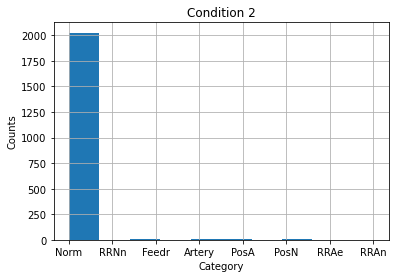

In [25]:
houses_imp.groupby('condition_2').mean()['saleprice']

houses_imp['condition_2'].hist().set(title='Condition 2', xlabel='Category', \
                                     ylabel = 'Counts',)
houses_imp['condition_2'].value_counts()

Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	

In [ ]:
houses

In [26]:
X = houses_imp.drop(columns = ['saleprice'])
y = houses_imp['saleprice']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = .25,
    random_state = 3
)

In [29]:
ohe = OneHotEncoder(
    drop = 'first',
    handle_unknown = 'ignore',
    sparse = False
)

In [31]:
ctx = ColumnTransformer(
    transformers = [
        #('alias_first', actual_transformer, list_of_cols_to_apply_to)
        ('one_hot', ohe,\
         houses.select_dtypes(include = ['object']).columns)
    ], remainder = 'passthrough', #don't drop the others
    verbose_feature_names_out = False
)

In [32]:
#transform train
ctx.fit(X_train)
X_train_enc = ctx.transform(X_train)

#transform test
X_val_enc = ctx.transform(X_val)

#recreate dataframes
X_train_enc = pd.DataFrame(X_train_enc, columns = ctx.get_feature_names_out())
X_val_enc = pd.DataFrame(X_val_enc, columns = ctx.get_feature_names_out())

X_train_enc.shape, X_val_enc.shape


/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 7, 9, 13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((1538, 242), (513, 242))

In [33]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train_enc,)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val_enc), columns = ss.get_feature_names_out())

### Modeling

The baseline model is given by an estimation of any house sale with the average sale price of previously seen house sales.

This baseline model will provide a standard for further modeling efforts.

The two statistics that will be used are RMSE, or root mean squared error, which represents the typical error in the prediction, and the R-squared statistic, which indicates the proportion of the variance in the target variable that is explained by the model.

In [49]:
pred_b = y_train.mean()

round((sum((y_val - pred_b).pow(2))/len(y_val))**.5,2), \
mean_squared_error(y_val, [pred_b]*len(y_val), squared = False).round(2)

(79420.42, 79420.42)

Above is the RMSE of the baseline model as shown by a self-made implementation as well as the sci-kit learn implementation.

In [51]:
r2_score(y_val, [pred_b]*len(y_val)).round(2)

-0.0

Above is the r2 score.  It is practically zero, which is to be expected for a baseline model and it indicates that no variance is explained by the model.

In [54]:
lr = LinearRegression()
lr.fit(Xs_train, y_train)
lr.score(Xs_train, y_train), lr.score(Xs_val, y_val)

(0.9467169812025749, 0.6642536751014341)

The baseline linear regression model substantially overfits the data, as seen by
the R-squared statistic, which represents the proportion of the variance
in sale price that is explained by the model.

In [43]:
linear_preds = lr.predict(Xs_val)

mean_squared_error(y_train,lr.predict(Xs_train), squared = False),\
mean_squared_error(y_val, linear_preds, squared = False),

(18277.62518208306, 45998.59578909338)

In [84]:
alphas = np.arange(.01,15,.1)
rcv = RidgeCV(alphas = alphas)
rcv.fit(Xs_train, y_train)
print(f'R-squared:{rcv.score(Xs_train, y_train), rcv.score(Xs_val, y_val)} RMSE: {mean_squared_error(y_train,rcv.predict(Xs_train), squared = False), mean_squared_error(y_val,rcv.predict(Xs_val), squared = False)}')


R-squared:(0.9432781795939493, 0.7608167029848245) RMSE: (18858.208634349812, 38824.36527541219)


Again we see evidence of overfitting demonstrated here by the R-squared and RMSE scores.
Lasso may lead to less overfitting and allow for better feature selection as well.

[RMSE formula](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)

In [100]:
lcv = LassoCV(alphas = np.arange(.001, 1000, 10))
lcv.fit(Xs_train, y_train)
lcv.score(Xs_train, y_train), lcv.score(Xs_val, y_val)

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1473773338.3902588, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3527904421.786804, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191524899550.79794, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packa

(0.9384585421814624, 0.7704579449478394)

In [101]:
lcv.score(Xs_train, y_train), lcv.score(Xs_val, y_val)

(0.9384585421814624, 0.7704579449478394)

In [102]:
lcv.alpha_

270.001

In [103]:
mean_squared_error(y_train,rcv.predict(Xs_train), squared = False), mean_squared_error(y_val,rcv.predict(Xs_val), squared = False)

(18858.208634349812, 38824.36527541219)

Unfortunately, there little difference between the lasso and ridge in terms of the r2 score and the rmse.  

Baseline Model will predict the y validation based on the average of the y train.

The baseline rmse for the validation set is $79,420.42

In [ ]:
lr = LinearRegression()
lr.fit(Xs_train, y_train)
lr.score(Xs_train, y_train), lr.score(Xs_val, y_val)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val,lr.predict(Xs_train), squared = False)

In [108]:
en = ElasticNetCV(l1_ratio=np.arange(.01,1,.01))


In [109]:
en.fit(Xs_train, y_train)
en.score(Xs_val,y_val)
best_alpha, best_l1_ratio = en.alpha_, en.l1_ratio_

In [110]:
best_alpha, best_l1_ratio, en.score(Xs_val,y_val), en.score(Xs_train,y_train)

(64.43575137533763, 0.99, 0.8459152684101263, 0.8960003279913095)

After adjusting the l1_ratio for ElasticNet, the best l1 ratio approaches 1 indicating that the lasso is the best model.  However, the elasticnet implementation is generating a better score than seen previously with the lasso, so I will proceed with the elastic net for examination of the coefficients.  

[coeficient plot source](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)

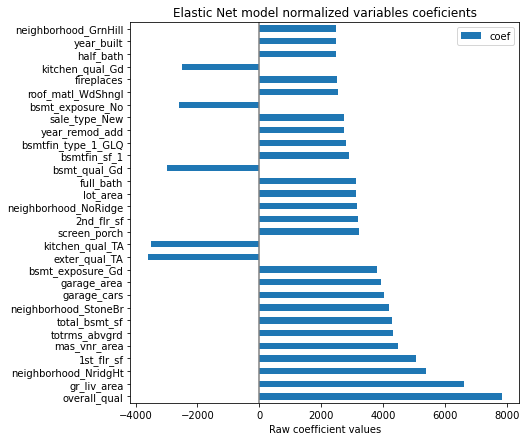

In [138]:
coefs = pd.DataFrame.from_dict({f_name: [coef,abs(coef)] for f_name, coef in 
 zip(en.feature_names_in_,en.coef_)},orient = 'index', columns = ['coef', 'abs_coef'])\
.sort_values('abs_coef', ascending = False).iloc[0:30,'coef']
coefs_sorted = pd.DataFrame(coefsb['coef'])
coefs_sorted
coefs_sorted.plot.barh(figsize=(9, 7))
plt.title("Elastic Net model normalized variables coeficients")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

I ran the three models as well as the elastic net.  curiously, elastic net with an l1 ration of almost one significantly outperforms on the validation lasso, while lasso and ridge perform equivalently.  

What I’m not sure of is how to interpret the raw coefficients, post standard scaling.  I guess I could talk about the change in price with a change in z-score of the variable, but it feels less clumsy to  divide the coefs by the sd of the feature.  not sure how to go about that.  Also, I had included the categorical variables in the standard scaling process, so these coefficients are not as interpretable as they could be.

In [ ]:
en.score(Xs_train, y_train), en.score(Xs_val, y_val)

In [ ]:
best_alpha 

In [ ]:
en.fit(pd.concat([Xs_train,Xs_val]),pd.concat([y_train,y_val]))
en.alpha_

In [ ]:
en.alpha_, en.l1_ratio_

In [ ]:
{feature: coef for coef, feature in zip(en.coef_,en.feature_names_in_)}

In [ ]:
houses_test_imp_enc = ctx.transform(houses_test_imp)
houses_test_imp_enc_ss = pd.DataFrame(ss.transform(houses_test_imp_enc), columns = ss.get_feature_names_out())

In [ ]:
en.alpha_

en_preds2 = en.predict(houses_test_imp_enc_ss)

en_preds2 = pd.DataFrame(en_preds2,columns = ['SalePrice'])

en_preds2.insert(loc = 0, column= 'Id', value = houses_test_id)

en_preds2.to_csv('./en_2_simple.csv', index = False)

In [ ]:
en